# FHR Baseline from Wróbel et al. 2013

## Summary

This notebook implements the method for FHR baseline calculation from Wróbel et al. 2013, based on the MATLAB implementation in the FHRMA package.

The paper: [Wróbel et al. 2013](https://doi.org/10.1016/j.bbe.2013.09.004) - Improving fetal heart rate signal interpretation by application of myriad filtering

## Paper description of the method

This method uses myriad filtering, with the stated benefit being that it does not require interpolation of signal loss segments (although we have already done that for all FHR records here).



## Python implementation

Import required packages

In [1]:
import math
import numpy as np
import pandas as pd
import sys

Import functions defined elsewhere

In [2]:
sys.path.append('/functions')
from functions.load_data import load_data
from functions.avg_subsample import avg_subsample
from functions.simple_acc_dec_validation import compare_means

Import datasets required for running the function and validation

In [3]:
raw_fhr, fhrma_base, fhrma_acc, fhrma_dec = load_data(fhrma_path = './data/W_std.mat')

Define functions for calculating baseline

In [4]:
def myriad(x, k2):
    '''
    Implements myriad filter, based on myriad() in FHRMA

    Parameters
    ----------
    x : array
        Subsample of sfhr
    k2 : numeric
        Not certain.
    '''
    # Get min and max of x, and create empty list for length of difference 
    # between the min and the max, plus 1
    ma = round(max(x))
    mi = round(min(x))
    myrs = np.zeros(ma-mi+1)

    # For values of i up to length of myrs, manipulate each value in x, then sum
    for i in np.arange(0, len(myrs)):
        myrs[i] = sum([math.log(k2+((f-i-mi)**2)) for f in x])

    # Get index of minimum
    m = np.argmin(myrs)

    # Add that index to the minimum value of x (plus 1 as Python is 0-indexed)
    m = m + mi + 1

    return (m)

In [5]:
def wrobel_baseline(fhr):
    '''
    Calculate FHR baseline using method from Wrobel et al. 2013, as implemented
    in MATLAB in the FHRMA toolbox

    Parameters
    ----------
    fhr : array
        Cleaned FHR
    '''
    # Find mean of every 10 records, generating shorter version of FHR (sfhr)
    sfhr = avg_subsample(fhr, 10)

    # Create array of zeros with same length of sFHR
    baseline = np.zeros(len(sfhr))

    for i in np.arange(1, len(sfhr)+1):
        # wins=161 for i <= 161, and wins=i-160 for i > 162
        # wine=i+160 for i < len(sfhr)-160, and wine=len(sfhr) for i >= len(sfhr)-160
        # No -1 for wine as MATLAB includes the final index but Python wouldn't
        wins = max(1, i-160)-1
        wine = min(len(sfhr), i+160)

        # Filter to that interval in sfhr, and set value of k2
        x = sfhr[wins:wine]
        k2 = 0.25

        # Set baseline to outcome of myriad function
        baseline[i-1] = myriad(x, k2)

    # Create array of zeros with length of original FHR
    full_baseline = np.zeros(len(fhr))

    # Get the index of each item in baseline, and find equivalent for full sequence
    indices = np.arange(0, len(baseline))*10
    indices[1:]-= 1

    # Set values
    full_baseline[indices] = baseline

    # Perform linear interpolation on the values in between (and not past them)
    max_index = (max(indices))+1
    full_baseline[:max_index][full_baseline[:max_index] == 0] = np.nan
    full_baseline = pd.Series(full_baseline).interpolate(method='linear').values

    return(full_baseline)

Compare against FHRMA

In [6]:
# Create dictionary to store results
python_wrobel = dict()

for key, value in raw_fhr.items():
    python_wrobel[key] = wrobel_baseline(value)
    print(f'{key} match: {(python_wrobel[key] == fhrma_base[key]).all()}')

train28 match: True
test80 match: True
test68 match: True
train04 match: True
train31 match: True
train13 match: True
train47 match: True
test70 match: True
test18 match: True
test38 match: True
test85 match: True
test69 match: True
train16 match: True
test73 match: True
train35 match: True
train60 match: False
train11 match: True
test03 match: False
train32 match: True
train12 match: True
test15 match: True
train06 match: True
train66 match: True
test26 match: True
test77 match: False
test02 match: True
test10 match: True
train20 match: True
test46 match: True
train15 match: True


KeyboardInterrupt: 

In [7]:
# Find mean of each record
python_df = pd.DataFrame({
    'record': python_wrobel.keys(),
    'python_mean': [round(np.mean(python_wrobel[i]),10) for i in python_wrobel.keys()]})
fhrma_df = pd.DataFrame({
    'record': fhrma_base.keys(),
    'fhrma_mean': [round(np.mean(fhrma_base[i]),10) for i in fhrma_base.keys()]})

# Combine into a single dataframe
compare_mean = pd.merge(python_df, fhrma_df, on='record')

# Add column with difference in means
compare_mean['diff'] = abs(compare_mean['python_mean'] - compare_mean['fhrma_mean'])

,record,python_mean,fhrma_mean,diff
24,test77,145.026184,145.026219,0.000036
15,train60,158.985294,158.985263,0.000031
17,test03,117.926308,117.926327,0.000019
1,test80,142.857543,142.857543,0.000000
28,test46,138.514170,138.514170,0.000000


diff
True     27
False     3
Name: count, dtype: int64

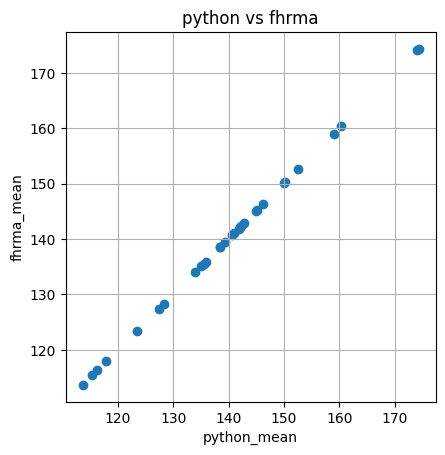

In [8]:
# Preview dataframe, starting with records with the greatest difference
display(compare_mean.sort_values(by='diff', ascending=False).head())

# Record how many are exactly the same
display((compare_mean['diff'] == 0).value_counts())

# Present in a figure
compare_means(compare_mean, 'python_mean', 'fhrma_mean', 'python vs fhrma')